# ***Exploratory Data Analysis* (EDA) Untuk Pengerjaan Tugas Akhir**

Nama: Nazhif Haidar Putra Wibowo

NIM : 18221083

## 1. **Pengaturan Awal**

Bagian ini meliputi proses hal-hal yang dilakukan untuk membaca dataset

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.9 MB/s eta 0:00:00


### Mengimpor Pustaka

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import contractions
from IPython.display import display_markdown
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import re
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Mengunduh Dataset

In [6]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


### Mengangkut dan membaca berkas dataset

In [9]:
PROJECT_PATH = "/content/drive/MyDrive/TA/Implementasi/datasets"

In [12]:
products = pd.read_csv(PROJECT_PATH+'/products_uk_clean.csv')
sessions = pd.read_csv(PROJECT_PATH+'/sessions_uk.csv')

display(products.head())
display(sessions.head())

,id,title,price,brand,color,size,model,material,author,desc,label
0,B087LZNPHS,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,color sherpa throw blanket available variety c...,219340
1,B08THFN1KX,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,competitively priced,283092
2,0804185328,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN,2966
3,B09VBKDBW6,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,aftersalethis handheld food heat sealer powere...,410858
4,B096ZW8B49,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,antifriction customer firsteach box product eq...,320496


,prev_items,next_item,locale
0,['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...,B07Y227WNJ,UK
1,['B07FM2GLNQ' 'B07GZW3P4W'],B095NNZCR6,UK
2,['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY'],B002KA1FZC,UK
3,['B0B2WSZYL2' 'B000I8XZ7O'],B000I90TAO,UK
4,['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...,B07H54NZ3K,UK


### Fungsi-fungsi Utilitas

In [13]:
def get_product(id):
    return products[products['id'] == id]

def handle_outlier(series, method='remove', factor=1.5):
    """
    Menangani pencilan dalam pandas Series dengan metode IQR

    Parameter:
        series (pd.Series): objek Series yang akan diproses.
        method (str): Bagaimana pencilan ditangani ('remove', 'cap', atau 'median').
                      - 'remove': Menghilang baris data yang memiliki pencilan secara menyeluruh.
                      - 'cap': Mengujungkan pencilan ke batas terdekat.
                      - 'median': Mengganti pencilan dengan median seri tersebut.
        factor (float): faktor dari IQR untuk menentukan ambang pencilan.

    Returns:
        pd.Series: Sebuah Series dengan pencilan tertangani.
    """
    # Hitung Q1, Q3, dan IQR
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    median_value = series.median()

    if method == 'remove':
        # Menghilangkan pencilan
        return series[(series >= lower_bound) & (series <= upper_bound)]
    elif method == 'cap':
        # Mengujungkan pencilan
        return series.clip(lower=lower_bound, upper=upper_bound)
    elif method == 'median':
        # Mengganti pencilan dengan median
        return series.apply(lambda x: x if lower_bound <= x <= upper_bound else median_value)
    else:
        raise ValueError("Metode tidak valid. Gunakan 'remove', 'cap', atau 'median'.")

def extended_describe(df, include_skew_kurt=True):
    '''
    Membuat deskripsi DataFrame yang menyertakan skewness dan kurtosis.
    '''
    # describe dengan cara semula
    desc = df.describe(percentiles=[0.05, 0.1, .25, .5, .75, 0.95, 0.99]).T

    if include_skew_kurt:
        # Pilih hanya kolom numerik
        numeric_df = df.select_dtypes(include=['number'])
        # tambah skewness dan kurtosis
        desc['skew'] = numeric_df.skew()
        desc['kurtosis'] = numeric_df.kurtosis()

    return desc

def count_length_session(session_str):
    try:
        session_str = re.sub(r'\[|\]', '', session_str) # Hilangkan tanda siku
        parsed_session = session_str.split() # Pisahkan berdasarkan spasi
        return len(parsed_session) + 1
    except (ValueError, SyntaxError):
        return 1


def show_word_cloud(df, column_name, title):
    # Join teks
    text = ' '.join(df[column_name].dropna().astype(str))

    # Configure and generate the word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,  # Use built-in stopwords
        max_words=200,
        colormap='viridis',   # Add a color scheme
        collocations=False    # Disable phrase detection
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14, pad=20)
    plt.tight_layout(pad=0)
    plt.show()

def generate_n_gram(n, text_array):
    if n < 2:
        raise ValueError('n harus lebih besar dari 1')

    # Tokenize the text
    tokenized_texts = [text.split() for text in text_array]

    # Generate n-grams for each text
    n_grams = []
    for tokens in tokenized_texts:
        if len(tokens) < n:
            continue

        # Generate n-grams for the current text
        text_n_grams = [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
        n_grams.append(text_n_grams)

    return n_grams





### Drop kolom yang tidak berguna ('locale')

In [14]:
products.drop('locale', axis=1, inplace=True)
sessions.drop('locale', axis=1, inplace=True)

KeyError: "['locale'] not found in axis"

## 2. **Proses Eksplorasi**

Bab ini memberikan tahapan-tahapan eksplorasi mengenai data dan visualisasinya agar lebih mudah dipahami oleh orang-orangb umum.

### Informasi Umum terkait Dataset

In [15]:
products.info()
print("\n===============================================\n")
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500180 entries, 0 to 500179
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        500180 non-null  object 
 1   title     500180 non-null  object 
 2   price     500180 non-null  float64
 3   brand     495898 non-null  object 
 4   color     378078 non-null  object 
 5   size      301092 non-null  object 
 6   model     243528 non-null  object 
 7   material  298955 non-null  object 
 8   author    18896 non-null   object 
 9   desc      460859 non-null  object 
 10  label     500180 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 42.0+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182181 entries, 0 to 1182180
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   prev_items  1182181 non-null  object
 1   next_item   1182181 non-null  object
 2   locale      1182181

### Ambil 100.000 data sesi

Sebab data sesi yang terlalu banyak, maka akan dipilih secara acak sesi yang akan digunakan pada pelatihan model. seed sudah ditentukan untuk memastikan setiap runnya konsisten

In [ ]:
SEED = 911

In [ ]:
# sessions = sessions.sample(n=100000, random_state=SEED)

# print(len(sessions))

### Saring data produk yang hanya ada di sesi

In [ ]:
# all_unique_items = set()

# for prev_items, next_items in zip(sessions['prev_items'], sessions['next_item']):
#     items = re.sub(r"\[|\]|\'", '', prev_items).split() + [next_items]
#     all_unique_items.update(items)



# products = products[products['id'].isin(all_unique_items)]

In [ ]:
def create_full_sequence(df: pd.DataFrame) -> list:
    prev_items = df['prev_items'].str.replace(r"[\[\]'\n\"]", '', regex=True).str.split()
    next_item = df['next_item'].astype(str)

    # Combine lists properly
    all_items = prev_items + next_item.apply(lambda x: [x])

    return all_items.tolist()

### Menghitung Banyaknya Data Kosong

In [ ]:
prod_value_count = products.isna().sum().reset_index(name='null_value_count')
session_value_count = sessions.isnull().sum().reset_index(name='null_value_count')
prod_value_count['null_percentage'] = (prod_value_count['null_value_count']/len(products)*100).round(2)
session_value_count['null_percentage'] = (session_value_count['null_value_count']/len(sessions)).round(2)
display_markdown("### Products Null Value Count", raw=True)
display(prod_value_count)
display_markdown("### Sessions Null Value Count", raw=True)
display(session_value_count)

### Statistika Deskriptif Dataset

In [ ]:
# tangani kolom 'price'
products_copy1 = products.copy()
products_copy1['price'] = handle_outlier(products_copy1['price'], method='median')

# tampilkan statistika deskriptif
pd.set_option('display.float_format', '{:.2f}'.format)
display_markdown("### Statistika Deskriptif Produk", raw=True)
display(extended_describe(products))
display_markdown("### Statistika Deskriptif Produk (Pencilan Ditangani)", raw=True)
display(extended_describe(products_copy1))
pd.reset_option('display.float_format')

### Analisis Panjang Sesi

### Lima Sesi Terpanjang

,prev_items,next_item,locale,session_length
993926,['B0789FQB9Z' 'B07895QS3B' 'B09K7W2RNQ' 'B0789...,B001RYQLRE,UK,202
617809,['B08TZZTL92' 'B097GHBG97' 'B07GD77YN8' 'B09JF...,B071ZD6QN2,UK,110
686538,['B08GK71BVR' 'B08GK6J1FR' 'B08Y8BKW7M' 'B08Y8...,B0821HQP6T,UK,100
415389,['B001NQHN7S' 'B001NQHN7S' 'B09WWF1JKN' 'B001A...,B09RB8C8G8,UK,96
700207,['B009Q8492W' 'B06ZZDRCDW' 'B009SK9CTS' 'B081S...,B009SKSWIU,UK,90


### Lima Panjang Sesi Terbanyak

,session_length,count
0,3,449320
1,4,248849
2,5,152794
3,6,97431
4,7,65199


### Statistika Deskriptif Panjang Sesi

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max,skew,kurtosis
session_length,1182181.0,5.121624,3.251626,3.0,3.0,3.0,3.0,4.0,6.0,11.0,18.0,202.0,3.841189,38.395484


### Distribusi Panjang Sesi

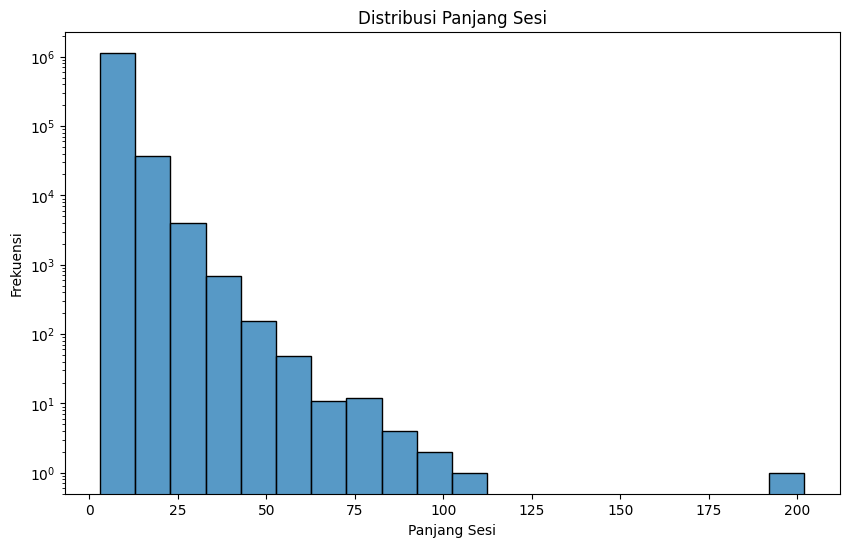

In [17]:
sessions['session_length'] = sessions['prev_items'].map(count_length_session)

# tampilkan lima sesi terpanjang
display_markdown("### Lima Sesi Terpanjang", raw=True)
display(sessions.nlargest(5, 'session_length'))

# tampilkan lima panjang sesi paling umum
display_markdown("### Lima Panjang Sesi Terbanyak", raw=True)
display(sessions['session_length'].value_counts().nlargest(5).reset_index())

# tampilkan statistika deskriptif panjang sesi
display_markdown("### Statistika Deskriptif Panjang Sesi", raw=True)
display(extended_describe(sessions[['session_length']]))

# tampilkan distribusi panjang sesi dengan anggota terbanyak
display_markdown("### Distribusi Panjang Sesi", raw=True)
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.title("Distribusi Panjang Sesi")
plt.xlabel('Panjang Sesi')
plt.ylabel('Frekuensi')
sns.histplot(sessions['session_length'], bins=20, kde=False)
plt.show()

### Distribusi Harga Produk

<Figure size 900x1500 with 0 Axes>

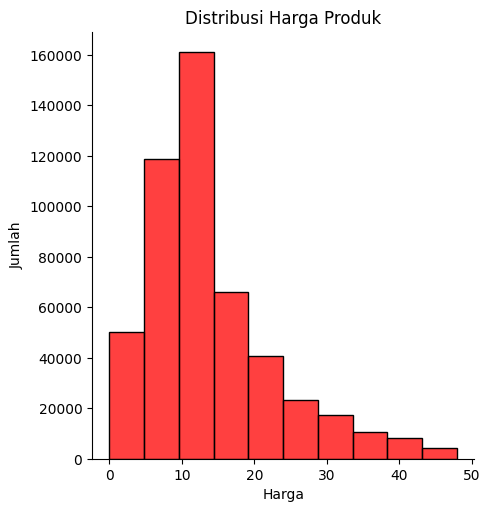

In [ ]:
plt.figure(figsize=(9,15))
sns.displot(products_copy1['price'], bins=10, color='red')
plt.title('Distribusi Harga Produk')
plt.xlabel('Harga')
plt.ylabel('Jumlah')
plt.show()

### Boxplot Harga Produk

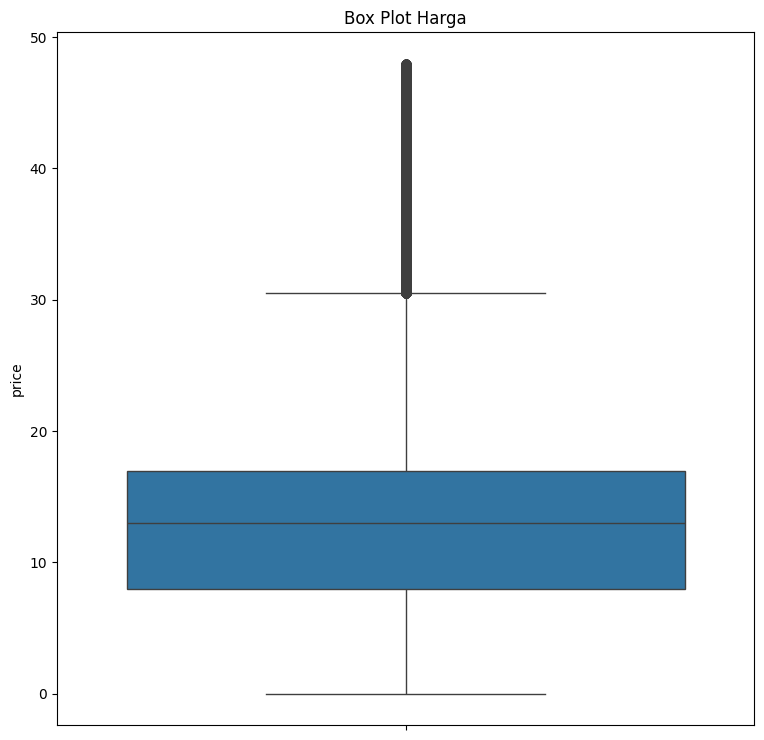

In [ ]:
plt.figure(figsize=(9,9))
plt.title("Box Plot Harga")
sns.boxplot(products_copy1['price'])
plt.show()

### Boxplot Panjang Sesi

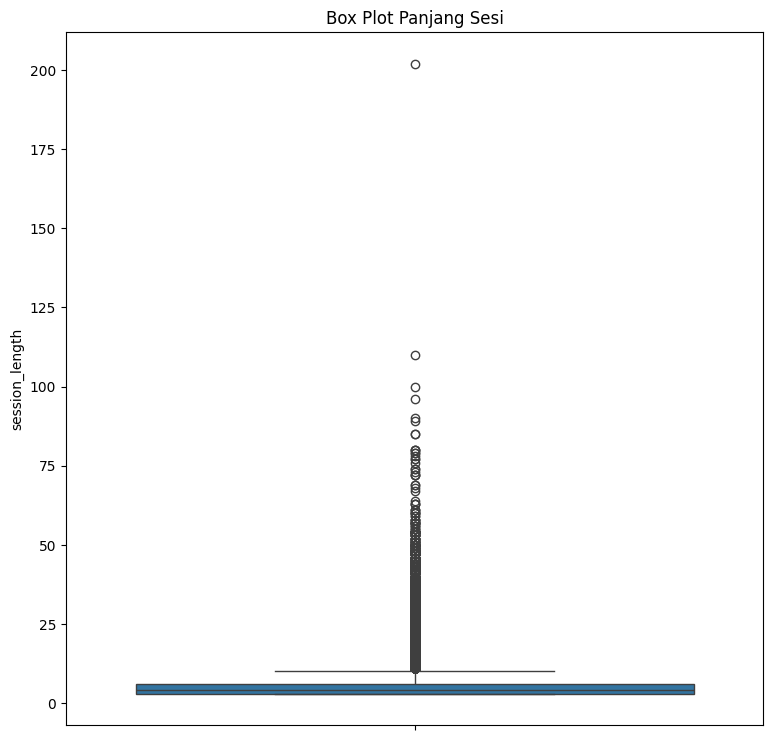

In [ ]:
plt.figure(figsize=(9,9))
plt.title("Box Plot Panjang Sesi")
sns.boxplot(sessions, y='session_length', orient='v')
plt.show()

## 3. **EDA Produk**

### Pembersihan Teks

In [ ]:
# Pembersihan deskripsi produk
def lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def clean_text(text,ignore_nan=True):
    if ignore_nan and pd.isna(text):
        return
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join(text.split())

    # expand contractions
    text = contractions.fix(text)

    # remove stopwords
    text = remove_stop_words(text)

    # Lemmatize text
    text = lemmatize(text)
    return text



products_copy1['desc'] = products_copy1['desc'].apply(clean_text)
# products_copy1['desc'].dtype

# Ambil 5 produk acak untuk ditampilkan
products_copy1['desc'].sample(5)

,desc
466993,box dimension 355 x 355 x 152 mm 14 x 14 x 6
242588,bed covered available wide range size single 1...
414364,compact tough cast aluminium profile
330537,cooking cakesbread pizzaside dishesquesadillas...
154486,None


### Top 10 Produk yang paling sering dilihat

In [ ]:
product_val_counts = {}

for index, session in sessions.iterrows():
    prev_items = session['prev_items']
    prev_items = re.sub(r"\[|\]|\'", '', prev_items) # Hilangkan tanda siku
    parsed_session = prev_items.split()
    items = parsed_session + [session['next_item']]
    for product_id in items:
        product_val_counts[product_id] = product_val_counts.get(product_id, 0) + 1

# sort the product
product_val_counts = dict(sorted(product_val_counts.items(), key=lambda item: item[1], reverse=True))

top_100000_products = dict(list(product_val_counts.items())[:100000])
# show the top 10 product
top_10_products = dict(list(top_100000_products.items())[:10])

# create dataframe that contains id, product title, and count
top_10_products_df = pd.DataFrame(list(top_10_products.items()), columns=['id', 'count'])
top_10_products_df = top_10_products_df.merge(products_copy1[['id', 'title']], on='id', how='left')
display(top_10_products_df)

,id,count,title
0,B08CN3G4N9,1903,Ninja Foodi Dual Zone Air Fryer [AF300UK] 2 Dr...
1,B07N8QY3YH,1760,"COSORI Air Fryer with 100 Recipes Cookbook, XX..."
2,B077B9X3SB,1318,Tower T17021 Family Size Air Fryer with Rapid ...
3,B001RYNMDA,1249,"Garnier Nutrisse Permanent Hair Dye, Natural-l..."
4,B07S9FXKZQ,1228,Snug Kids Ear Defenders - Noise Cancelling Hea...
5,B01KNWYGMW,1174,"AnanBros Scary LED Halloween Mask, Light up Ma..."
6,B0B18DBBFB,1131,"Halloween Masks, Jsdoin Scary LED Purge Mask, ..."
7,B08PKLFM9T,1126,"iPhone Charger Cable, Lightning Cable 3Pack 3F..."
8,B0B18CK9DV,1098,"Halloween Masks, Jsdoin Scary LED Purge Mask, ..."
9,B08F2NDB39,1067,"iPhone Charger Cable, Lightning Cable 3Pack 6F..."


### Analisis Word Cloud untuk judul produk dan deskripsi

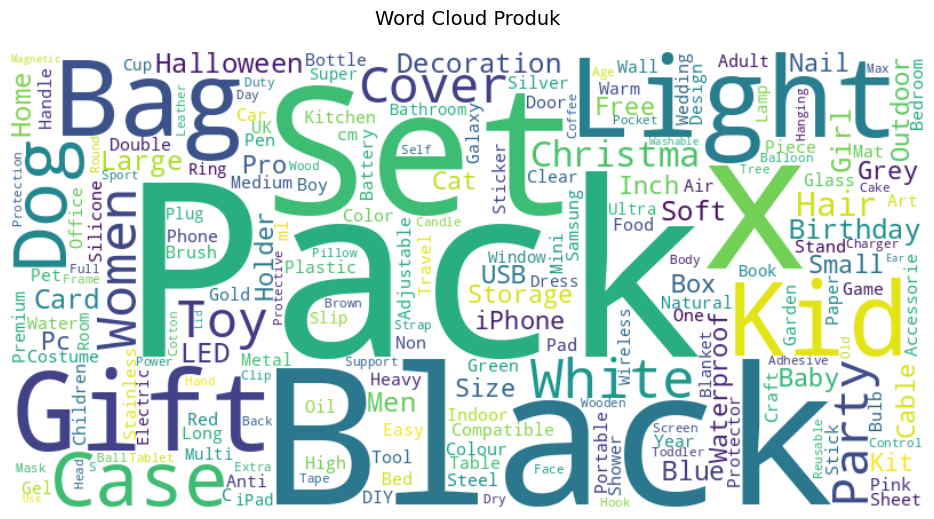

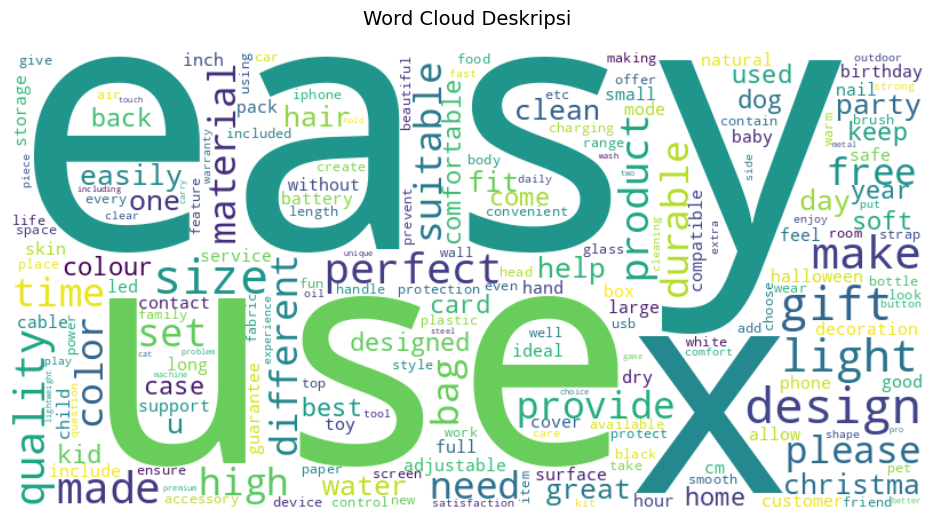

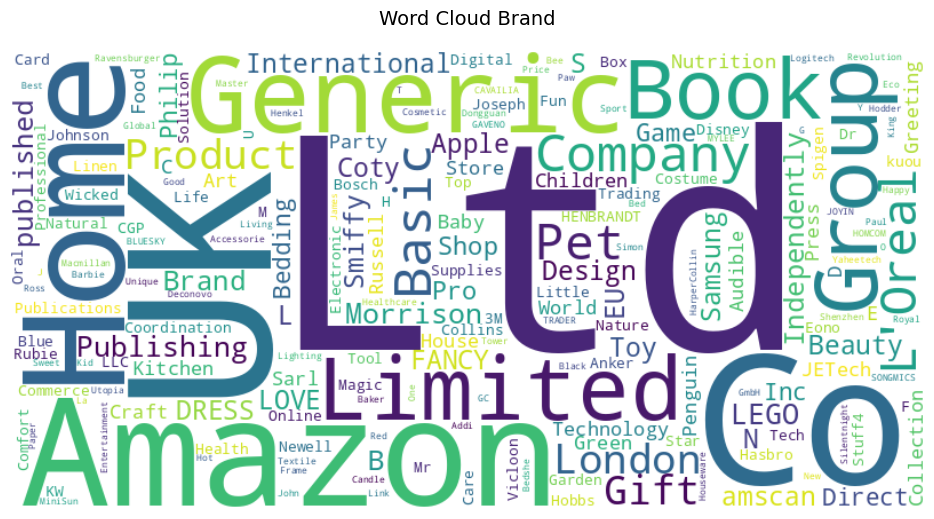

In [ ]:
# Start from The product title
show_word_cloud(products_copy1, 'title', 'Word Cloud Produk')

# Next, onto the product description
show_word_cloud(products_copy1, 'desc', 'Word Cloud Deskripsi')

# Next, onto the product brand
show_word_cloud(products_copy1, 'brand', 'Word Cloud Brand')

### Analisis N-gram (2-gram dan 3-gram)

Dalam bagian ini, akan dianalisis bigram dan triigram yang sering muncul pada dataset

In [ ]:
descriptions = products_copy1['desc'].dropna().astype(str)
bigrams = generate_n_gram(2, descriptions)
trigrams = generate_n_gram(3, descriptions)

# Flatten the lists
bigrams = [item for sublist in bigrams for item in sublist]
trigrams = [item for sublist in trigrams for item in sublist]

# Value counts each n-grams and pick top 10 most frequents
bigram_counts = pd.Series(bigrams).value_counts().head(10)
trigram_counts = pd.Series(trigrams).value_counts().head(10)



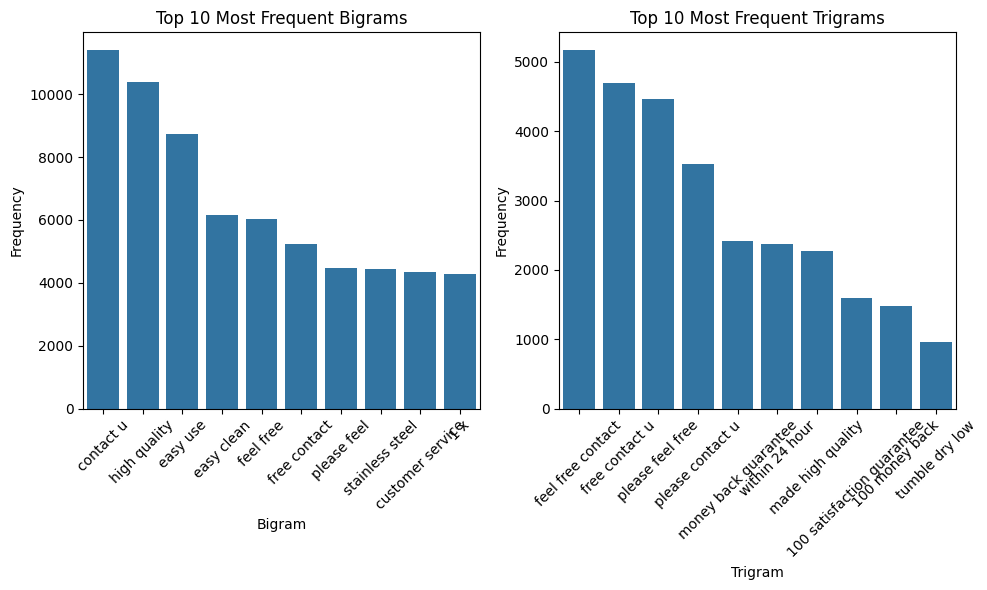

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=bigram_counts.index, y=bigram_counts.values)
plt.title('Top 10 Most Frequent Bigrams')
plt.xlabel('Bigram')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.barplot(x=trigram_counts.index, y=trigram_counts.values)
plt.title('Top 10 Most Frequent Trigrams')
plt.xlabel('Trigram')
plt.xticks(rotation=45)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## EDA Sesi

## Filter sesi hanya bagian dari top 100000 produk

In [ ]:
# all_unique_items = set()

# for prev_items, next_items in zip(sessions['prev_items'], sessions['next_item']):
#     items = re.sub(r"\[|\]|\'", '', prev_items).split() + [next_items]
#     all_unique_items.update(items)



# products = products[products['id'].isin(all_unique_items)]

### Analisis Sequence

## Ekspor Data yang telah dibersihkan

In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder
my_le = LabelEncoder()
products_copy1['label'] = my_le.fit_transform(products_copy1['id'])




In [ ]:
products_copy1.to_csv('products_uk_clean.csv', index=False)
sessions.to_csv('sessions_uk_clean.csv', index=False)

## Download the file
from google.colab import files
files.download('products_uk_clean.csv')
files.download('sessions_uk_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
display(sessions)

,prev_items,next_item,session_length
0,['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...,B07Y227WNJ,5
1,['B07FM2GLNQ' 'B07GZW3P4W'],B095NNZCR6,3
2,['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY'],B002KA1FZC,4
3,['B0B2WSZYL2' 'B000I8XZ7O'],B000I90TAO,3
4,['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...,B07H54NZ3K,5
...,...,...,...
1182176,['B06XK89969' 'B01NGT5NF4' 'B00D5Z89C8' 'B07ZV...,B07VL2W1DR,9
1182177,['B076M85W1K' 'B07L8792Q9' 'B095RW318L' 'B095R...,B095RQ2LCY,5
1182178,['B00JQDIQRQ' 'B001O59QQE'],B088M5YT6Y,3
1182179,['B07QMHMLJZ' 'B07FPYYMC4'],B07PFF814D,3


In [ ]:


from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

# Precompute the dictionary mapping (fastest possible lookup)
mapping = {item: idx for idx, item in enumerate(my_le.classes_)}

# Split data into chunks for parallel processing
def chunker(seq, chunk_size):
    return (seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size))

# Worker function for parallel processing
def process_chunk(chunk, mapping):
    return [[mapping[item] for item in sublist] for sublist in chunk]

# Parallel execution with chunking and progress tracking
def parallel_transform(sequences, mapping, n_jobs=-1, chunk_size=1000):
    chunks = list(chunker(sequences, chunk_size))
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk, mapping) for chunk in tqdm(chunks, desc="Processing chunks", unit="chunk")
    )

    return [sublist for chunk in results for sublist in chunk]

In [ ]:
print(sessions.head())

                                          prev_items   next_item  \
0  ['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...  B07Y227WNJ   
1                        ['B07FM2GLNQ' 'B07GZW3P4W']  B095NNZCR6   
2           ['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY']  B002KA1FZC   
3                        ['B0B2WSZYL2' 'B000I8XZ7O']  B000I90TAO   
4  ['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...  B07H54NZ3K   

   session_length  
0               5  
1               3  
2               4  
3               3  
4               5  


In [ ]:
sequences = create_full_sequence(sessions)
print(sequences[0])

['B0BFDL54Y7', 'B0BFDR9X13', 'B07J4WF8VH', 'B07Y21LDJX', 'B07Y227WNJ']


### Label Encoding masing-masing produk

In [ ]:
import json

# # Convert DataFrame to JSON string
transformed = parallel_transform(sequences, mapping)

df_transformed = pd.Series(transformed).reset_index(name="sequence")

Processing chunks: 100%|██████████| 1183/1183 [06:55<00:00,  2.84chunk/s]


In [ ]:
df_transformed.head()

,index,sequence
0,0,"[489206, 489237, 142933, 188025, 188028]"
1,1,"[133985, 138876, 315348]"
2,2,"[19817, 129680, 129680, 20979]"
3,3,"[443147, 12620, 12621]"
4,4,"[55082, 55082, 57935, 359096, 139532]"


In [ ]:
df_transformed.rename(columns={'index': 'session_id'}, inplace=True)

In [ ]:
df_transformed.head()

,session_id,sequence
0,0,"[489206, 489237, 142933, 188025, 188028]"
1,1,"[133985, 138876, 315348]"
2,2,"[19817, 129680, 129680, 20979]"
3,3,"[443147, 12620, 12621]"
4,4,"[55082, 55082, 57935, 359096, 139532]"


In [ ]:
df_transformed.to_csv('sessions_transformed.csv', index=False)

In [ ]:
# save the label encoder as joblib file
joblib.dump(my_le, 'product_id_encoder.joblib')

# download the encoder
files.download('product_id_encoder.joblib')

# download the session
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('sessions_transformed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>